# Pregunta 6

(2 puntos) La imagen Ex3Preg6(a).tif muestra una imagen tomada con un microscopio de cultivo de bacterias identificadas por los círculos intensos:

a. (0.5 puntos) Usando una técnica de umbralización global, segmente la imagen y muestre el resultado de la segmetnación.

b. (0.5 puntos) A la imagenoriginal se le aplicó una umbralización con valores locales yal resultado se le realizó una apertura morbológica obteniendo la imagen Ex3Preg6(b).tif. Usando esta imagen,cuente y etiquete cuantos objetos de la segmentación pueden considerarse células independientes. 

c. (1 punto) Continuando con la imagen anterior. Cuente y etiquete cuantos objetos de la segmentación pueden considerarse 2 células agrupadas, y cuantos y cuales más de 2 células.

In [150]:
# Functional programing tools : 
from functools import partial, reduce

# Visualisation : 
import matplotlib.pyplot as plt
import matplotlib.image as pim
import matplotlib.patches as mpatches
import seaborn as sns

# Data tools :
import numpy as np
import pandas as pd

# Image processing : 
import cv2 as cv
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

# Machine Learning :
from sklearn.cluster import KMeans

# Jupyter reimport utils :
import importlib

In [130]:
# Custom :
import mfilt_funcs as mfs
importlib.reload(mfs)
import mfilt_funcs as mfs


import utils
importlib.reload(utils)
import utils

In [3]:
#plt.style.available

In [39]:
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (10, 5)

In [77]:
img     = cv.imread('imagenes/Ex3Preg6(a).tif', cv.IMREAD_GRAYSCALE)
color   = cv.cvtColor(img, cv.COLOR_GRAY2RGB) # Color copy, to draw colored circles

a. (0.5 puntos) Usando una técnica de umbralización global, segmente la imagen y muestre el resultado de la segmetnación.

In [94]:
intensities = pd.core.frame.DataFrame(dict(intensity=img.flatten()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c30643b50>]],
      dtype=object)

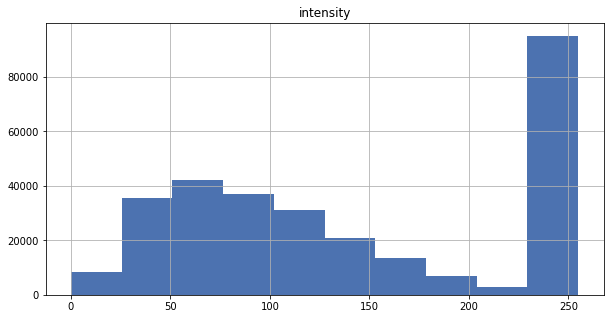

In [95]:
intensities.hist()

In [96]:
kmeans = KMeans(n_clusters=2, random_state=0, verbose=False).fit(intensities)
K = kmeans.cluster_centers_.mean()

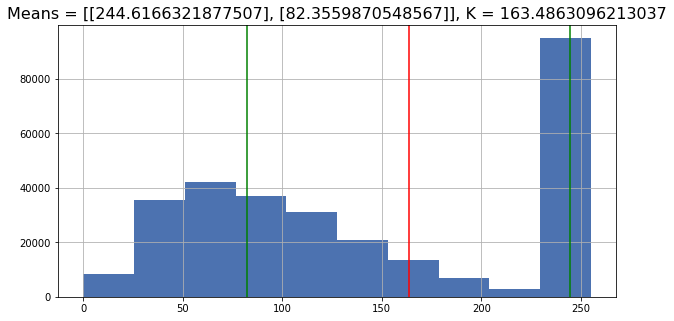

In [97]:
intensities.hist()
plt.axvline(K, color='r')
list(map(lambda x: plt.axvline(x, color='g'), kmeans.cluster_centers_))
_ = plt.title(f"Means = {kmeans.cluster_centers_.tolist()}, K = {K}", size=16)

In [99]:
thresh1 = cv.threshold(img, K, 255, cv.THRESH_BINARY)[1]

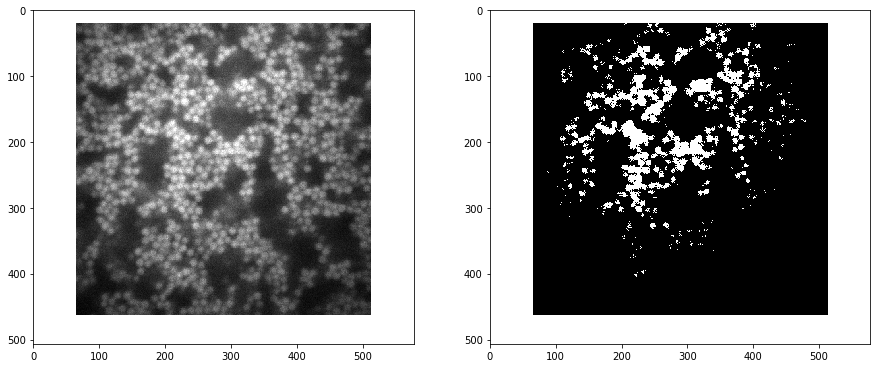

In [100]:
utils.side_by_side(img, thresh1)

Como podemos ver, una técinca de umbralización estándar como k-medias móviles, con dos medias, da resultados muy pobres.

In [101]:
otsu1 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

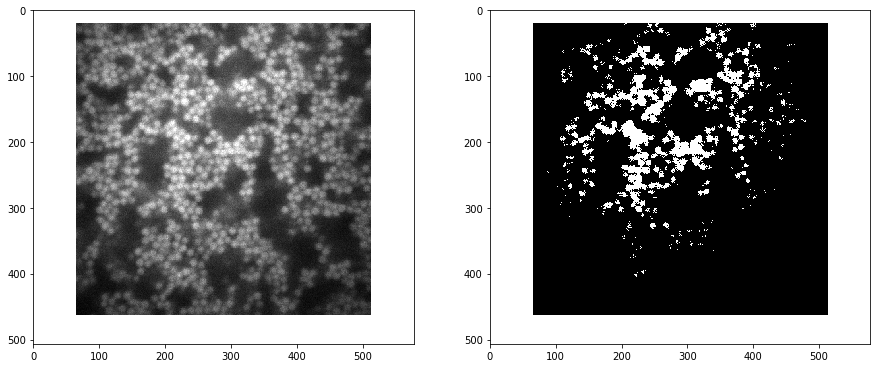

In [102]:
utils.side_by_side(img, otsu1)

El algoritmo de Otsu no logra mejorar mucho la segmentación (esto era de esperarse dado que el histograma original era claramente bimodal). 

In [109]:
gblur = cv.GaussianBlur(img,(3,3),0)
otsu2 = cv.threshold(gblur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

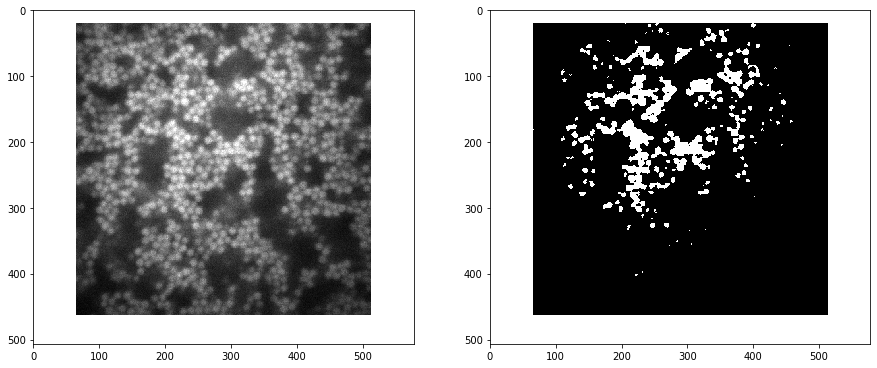

In [110]:
utils.side_by_side(img, otsu2)

El algoritmo de Otsu no logra mejorar mucho la segmentación aún en combinación con un suavizado Gaussiano.

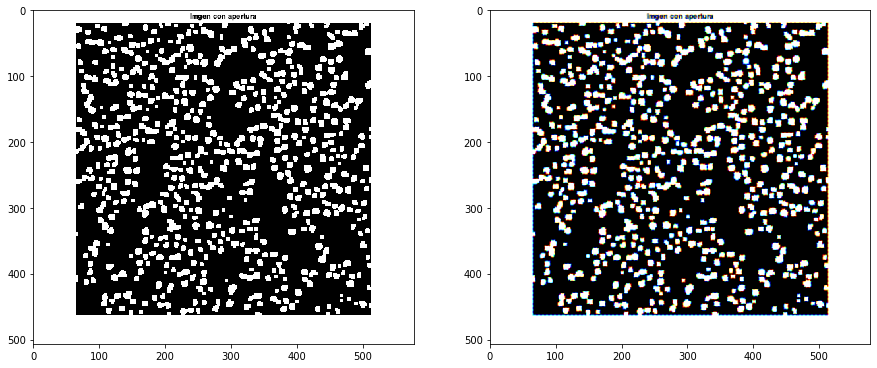

In [136]:
imgb = cv.imread('imagenes/Ex3Preg6(b).tif', cv.IMREAD_GRAYSCALE)
imgbc = cv.cvtColor(imgb, cv.COLOR_BAYER_GB2RGB)
utils.side_by_side(imgb, imgbc)

In [142]:
circles = cv.HoughCircles(imgb, cv.HOUGH_GRADIENT, 1, img.shape[0]/64, param1=200, param2=10, minRadius=5, maxRadius=15)

In [143]:
# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # Draw outer circle
        cv.circle(imgbc, (i[0], i[1]), i[2], (155, 0, 0), 2)

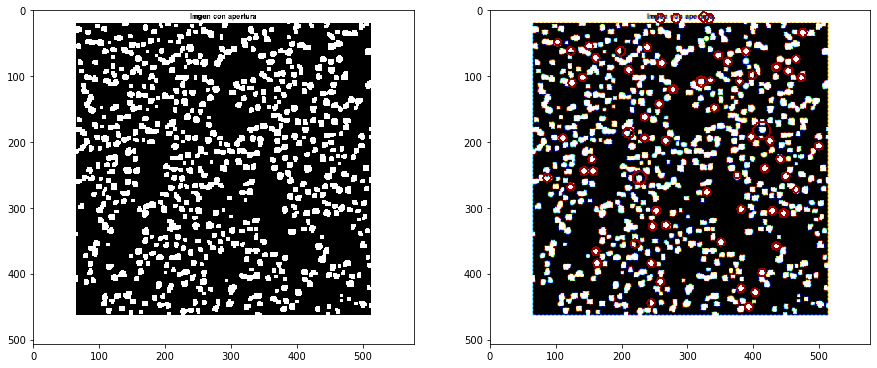

In [144]:
utils.side_by_side(imgb, imgbc)

# Extra

In [115]:
# Blur the image to reduce noise
img_blur = cv.medianBlur(img, 5)

In [116]:
# Apply hough transform on the image
circles = cv.HoughCircles(img_blur, cv.HOUGH_GRADIENT, 1, img.shape[0]/64, param1=200, param2=10, minRadius=5, maxRadius=7)

In [117]:
# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # Draw outer circle
        cv.circle(img, (i[0], i[1]), i[2], (0, 0, 255), 2)
        # Draw inner circle
        #cv2.circle(img, (i[0], i[1]), 2, (0, 0, 255), 3)

In [121]:
#plt.imshow(img)
img.shape

(507, 578)

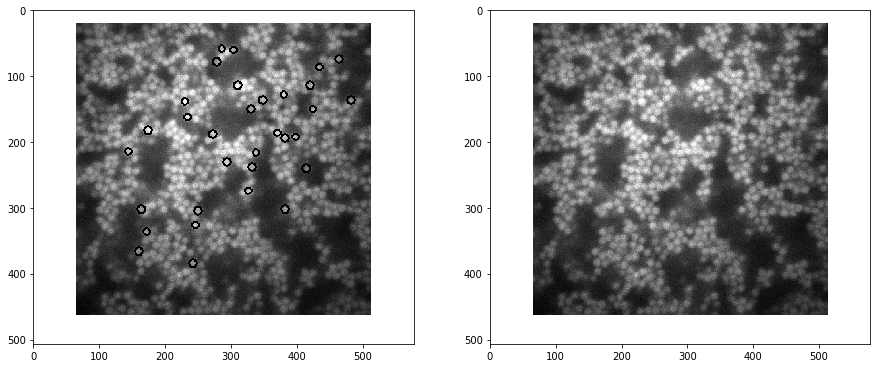

In [119]:
utils.side_by_side(img, color)

855


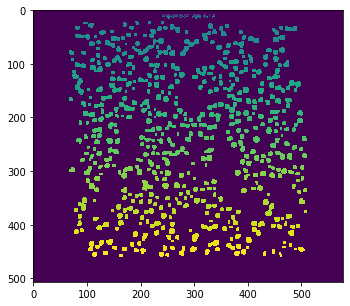

In [162]:
label_image, n_objs = label(imgb, return_num=True)
plt.imshow(label_image)
print(n_objs)

# Scikit-Image example :

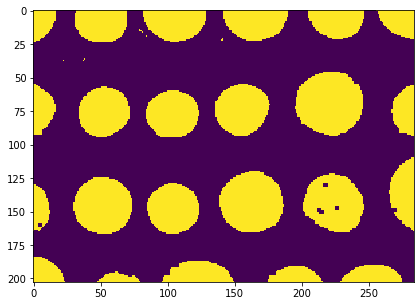

In [151]:
image = data.coins()[50:-50, 50:-50]

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))
plt.imshow(bw)

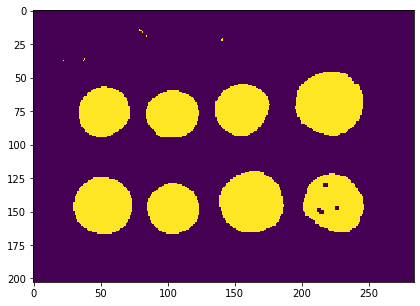

In [152]:
# remove artifacts connected to image border
cleared = clear_border(bw)
plt.imshow(cleared)

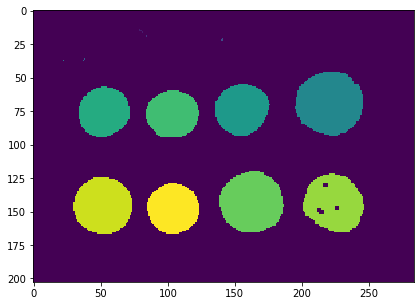

In [154]:
# label image regions
label_image = label(cleared)
plt.imshow(label_image)

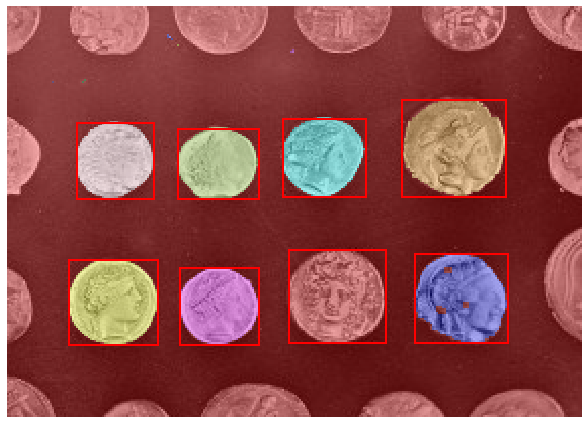

In [155]:
image_label_overlay = label2rgb(label_image, image=image)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [147]:
#help(cv2.HoughCircles)

In [148]:
#help(cv2.cvtColor)

In [158]:
help(label)

Help on function label in module skimage.measure._label:

label(input, neighbors=None, background=None, return_num=False, connectivity=None)
    Label connected regions of an integer array.
    
    Two pixels are connected when they are neighbors and have the same value.
    In 2D, they can be neighbors either in a 1- or 2-connected sense.
    The value refers to the maximum number of orthogonal hops to consider a
    pixel/voxel a neighbor::
    
      1-connectivity     2-connectivity     diagonal connection close-up
    
           [ ]           [ ]  [ ]  [ ]             [ ]
            |               \  |  /                 |  <- hop 2
      [ ]--[x]--[ ]      [ ]--[x]--[ ]        [x]--[ ]
            |               /  |  \             hop 1
           [ ]           [ ]  [ ]  [ ]
    
    Parameters
    ----------
    input : ndarray of dtype int
        Image to label.
    neighbors : {4, 8}, int, optional
        Whether to use 4- or 8-"connectivity".
        In 3D, 4-"connect